# AP03MP: Estimating albedo for different surface types using multiple wavelength satellite-borne radiance sensor data

### Preamble function definitions:

In [204]:
""" This is a demonstration of some basic data handling of Meteosat images
    which might be useful as a basis for the AP03 miniproject 
 
    There are two class definitions, Image and Geo, followed by the main program
"""

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sys
import pandas as pd

#-------------------------------------------------------------------------------
class Image:  
  """ Image data and methods 

  DATA
    tem   boo : True=brightness temperature image, False=radiance image
    nx    int : No of horizontal pixels in images
    ny    int : No of vertical pixels in images
    ixoff int : pixel offset of left edge of box
    iyoff int : pixel offset of bottom edge of box
    data  flt : np.(ny,nx) image data as 2D array
    title str : image title 

  METHODS 
    __init__ : Initialise new Img object
        disp : Display full disk image
        clip : Create new image from subset of original image
      bright : Convert radiance image to Brightness Temperature image
      cloud  : Remove cloud from image

  HISTORY
      v16Oct20 : AD Original version
  """

  def __init__(self,imgfil,title=None):
    """ Initialise new image object 

    PARAMETERS
      imgfil str : file name for image
      title  str : description of image

    DESCRIPTION
      Read in image data as 2D array of floating values.
      If called with imgfil==None this just creates a new 'empty' object 
      If called without title parameter, the title will be taken from the file
    """

    self.tem = False    # Assume any new image is radiance
    self.ixoff = 0
    self.iyoff = 0
    if imgfil is None:  # Create an empty object
      self.nx = 0
      self.ny = 0
      self.data = 0
      self.title = ''
    else:               # Read in image data from file
      with open(imgfil) as f:
        imgtitle = f.readline()
        if title is None: self.title=imgtitle
        else: self.title=title
        nx, ny = np.fromfile(f,dtype=int,count=2,sep=" ")  
        self.nx = nx
        self.ny = ny
        imgdata = np.fromfile(f, dtype=float, count=nx*ny, sep=" ")
        self.data = imgdata.reshape((ny,nx))

  def disp(self,window=1,box=None):
    """ Display the image 

    PARAMETERS
      window int : plot window for display
      box        : box coordinates, dictionary containing keys
        'xmin'  int : Pixel# of left edge of box
        'xmax'  int : Pixel# of right edge of box
        'ymin'  int : Pixel# of bottom edge of box
        'ymax'  int : Pixel# of top edge of box
        'color' str : (optional, default='white') color of box

    DESCRIPTION
      Basic function is to display the stored image self.data
      Can also superimpose a rectangular box defined by keys 'xm

    """
    plt.figure(window)
    plt.clf()
    plt.axis('off')                  # no axes required
    plt.title(self.title)
    if self.tem:                     # colour scale for bright.tem image
      colours = [(1,1,1),(1,0,1),(0,0,1),(0,1,1),(0,1,0),(1,1,0),
                 (1,0,0),(0,0,0)]
      tnorm = plt.Normalize(230,320) # range 230-320K
      tcmap = LinearSegmentedColormap.from_list('tem_colours', colours)
      plt.imshow(self.data, origin='lower', cmap=tcmap, norm=tnorm)
      plt.colorbar(label='Temperature [K]')
    else:                            # use gray scale for radiance image
      plt.imshow(self.data, origin='lower', cmap='gray')
      plt.colorbar(label='Radiance')
    if box is not None:
      xmin = box['xmin'] - self.ixoff
      xmax = box['xmax'] - self.ixoff
      ymin = box['ymin'] - self.iyoff
      ymax = box['ymax'] - self.iyoff
      if 'color' in box: col=box['color']
      else: col='white'
      plt.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin],color=col)
           
    plt.tight_layout(pad=0.05)       # maximise size of image within window
    plt.show()

  def clip ( self, box, title=None ):
    """ Create a new image from a subset of another image

    PARAMETERS
      box   dict : Subsect coordinates, as defined in self.disp
      title str  : Title for new image (else copy original image title)

    RETURNS
      newimg : Image object

    DESCRIPTION
      Creates a new image object from a rectangular subset of an existing image
      Note that pixel numbers from the original image have to be preserved, via
      self.ixoff and self.iyoff, in order for the geolocation to work on the
      subset image
    """
    xmin = box['xmin']
    xmax = box['xmax']
    ymin = box['ymin']
    ymax = box['ymax']
    newimg = Image(None)  
    newimg.nx = xmax-xmin 
    newimg.ny = ymax-ymin
    newimg.ixoff = xmin
    newimg.iyoff = ymin
    y1 = ymin - self.iyoff
    y2 = ymax - self.iyoff
    x1 = xmin - self.ixoff
    x2 = xmax - self.ixoff
    newimg.data = self.data[y1:y2,x1:x2]
    if title is None: newimg.title = self.title
    else: newimg.title = title
    return newimg

  def bright ( self, wavelength ):
    """ Convert radiance image to Brightness Temperature image

    PARAMETERS
      wavelength flt : characteristic wavelength [microns] for channel

    DESCRIPTION
      Convert image from radiance [W/(m2 sr um) to brightness temperature [K]
      using the inverse of the Planck function at the characteristic 
      wavelength. 
    """
    # Local constants
    H = 6.63e-34       # Planck constant       [m2 kg / s]
    C = 3.00e8         # Speed of light        [m / s]
    K = 1.38e-23       # Boltzmann constant    [m2 kg /s2 /K]
    R1 = H * C / K     # Intermediate Constant [m K]
    R2 = 2 * H * C**2  # Intermediate Constant [m4 kg / s3]
    if self.tem:
      print('Apparently already a brightness temperature image')
    else: 
      w = wavelength * 1.0e-6  # convert microns to metres
      self.data = R1 / w / np.log( 1.0 + R2/(w**5 * self.data*1e6) )
      self.tem = True

  def clouds(self, time):
    """Original method as provided in example code
    Converted into a callable function
    Clears cloud from input image
    """

    # Image for cloud clearing is input image
    image = self

    # Modify the time input to get the required format
    hour = time
    hour_str = str(hour)
    if len(str(hour)) == 1:
      hour_str = '0{}'.format(hour)

    # load in required channel 1&9 images for cloud clearing:
    c1 = Image('msg_c01_z{}.img'.format(hour_str))
    c9 = Image('msg_c09_z{}.img'.format(hour_str))

    # Convert channel 9 radiance to brightness temperature
    c9.bright(wavelength=10.79)

    # convert 2D images to 1D arrays
    c1vec = c1.data.flatten()
    c9vec = c9.data.flatten()

    # Set the threshold values for cloud detection
    c9cld = 290   # Brightness temp (K) (Ocean: 293, Forest: XXX, Desert: YYY)
    c1cld = 100   # Radiance threshold (Ocean: 60, Forest: XX, Desert: YY)

    # Apply cloudmask:
    # True = cloud-free, False = cloudy
    c1mask = c1.data.__lt__(c1cld) 
    c9mask = c9.data.__gt__(c9cld)
    cloudmask = np.logical_and(c1mask,c9mask)

    #c1.data = np.where(cloudmask,c1.data,100) # Set cloudy data to Rad=100
    #c9b.data = np.where(cloudmask,c9.data,200) # Set cloudy data to T=200K

    image.data = np.where(cloudmask,c1.data,100) # Set cloudy areas in input image to radiance = 100

    return(image)

In [205]:
# ------------------------------------------------------------------------------
class Geo:
  """ Geometric calibration data and methods

  DATA 
    cal    boo : True = Geoetric calibration set
    alpha  flt : y/elevation scale factor
    beta   flt : x/azimuth   scale factor
    x0     flt : x-coordinate of sub-satellite point
    y0     flt : y-coordinate of sub-satellite point
    geofil str : Name of file containing GeoCal data (eg 'geo.txt')

 METHODS
    __init__ : Initialise new Geo object   
      menu   : Screen menu for GeoCal part of practical
      save   : Write GeoCal data to file     
      input  : Read user-input of GeoCal parameters 
      angles : Print Elevation,Azimuth angles for givem Lat,Lon
      locang : Convert ele,azi angles to lat,lon,zen angles
      locate : Convert ix,iy coords to lat,lon,zen angles
      satang : Convert lat,lon angles to ele,azi,zen angles
      coords : Convert lat,lon angles to ix,iy coords

  USAGE
    Called once at the start to initialise a Geo object

  HISTORY
    v16Oct20 : AD Original version
  """
 
  def __init__(self,geofil):
    """ Initialise new Geo object

    PARAMETERS
      geofil str : name of file containing geo.cal data, eg 'geo.txt' 

    DESCRIPTION
      If the Geo Cal data file exists, the data are read on initialisation
      and geo.cal set True
    """

    # Local constants
    self.DIST = 42260.0      # Radial dist [km] of sat. from centre of earth
    self.REARTH  = 6371.0    # Earth radius [km]

    try:                     # if file already exists ...
      f = open(geofil,"r")
      rec = f.readline()  
      rec = f.readline()
      flds = rec.split()
      self.y0    = float(flds[0])   # y-coordinate of sub-satellite point
      self.x0    = float(flds[1])   # x-coordinate of sub-satellite point
      self.alpha = float(flds[2])   # y/elevation scale factor
      self.beta  = float(flds[3])   # x/azimuth   scale factor
      f.close()
      self.cal = True               # Flag for GeoCal data set
      print(" *** GeoCal data loaded from file: " + geofil)
    except:                         # file doesn't exist or can't be read
      print(" *** GeoCal data file not found/read: " + geofil)

  def locang(self,ele,azi):
    """ Convert ele,azi angles to lat,lon,zen angles

    PARAMETERS
      ele flt : Elevation angle [deg]
      azi flt : Azimuth angle [deg]

    RETURNS
      lat flt : Latitude [deg N]
      lon flt : Longitude [deg E]
      zen flt : Zenith angle [deg]

    DESCRIPTION
      The inverse of SATANG.
      Uses spherical coordinate geometry to find the point of intersection of a 
      ray leaving the satellite at particular ele,azi angle with the earth 
      surface
      If no intersection, returns (np.nan,np.nan,np.nan) instead.
    """
    rele     = math.radians(ele)
    sinele   = math.sin(rele)
    cosele   = math.cos(rele)
    razi     = math.radians(azi)
    sinazi   = math.sin(razi)
    cosazi   = math.cos(razi)
    # Distance of plane of intersection from centre of earth
    h = self.DIST * sinele 
    if abs(h) > self.REARTH: return (np.nan,np.nan,np.nan)  # no sfc intersect.
    r1 = math.sqrt( self.REARTH**2 - h**2 ) # Radius of circle of intersection
    d1 = self.DIST * cosele
    if abs ( d1 * sinazi ) > r1: return (np.nan,np.nan,np.nan) # No intersection
    # Distance of line of sight
    x = d1 * cosazi - math.sqrt( r1**2 - d1**2 * sinazi**2 )
    # Distance from pixel to point of intersection of earth's vertical axis with
    # plane of intersection
    d2 = self.DIST / cosele
    y = x**2 + d2**2 - 2 * x * d2 * cosazi
    if y < 0.0: y = 0.0
    y = math.sqrt(y)
    h1 = self.DIST * math.tan(rele)
    if abs(h1) > 1.0e-10:     
      gamma = math.acos( ( self.REARTH**2 + h1**2 - y**2 ) / 
                         ( 2.0 * self.REARTH * h1 ) ) 
    else:
      gamma = math.pi / 2.0 - h1 / ( 2.0 * self.REARTH )
    rlat = math.pi / 2.0 - gamma
    gamma1 = math.asin ( sinazi * x / y )
    rlon = math.atan ( math.sin(gamma1) / ( math.cos(gamma1) * cosele ) )
    rzen = math.acos ( cosazi * cosele ) + \
           math.acos ( math.cos(rlat) * math.cos(rlon) )
    lat = math.degrees(rlat)
    lon = math.degrees(rlon)
    zen = math.degrees(rzen)
    return ( lat, lon, zen )

  def locate(self,ix,iy):
    """ Convert ix,iy coords to lat,lon,zen angles

    PARAMETERS
      ix int : Current pixel x-coordinate
      iy int : Current pixel y-coordinate 

    RETURNS
      lat flt : Latitude [deg N]
      lon flt : Longitude [deg E]
      zen flt : Zenith angle [deg]

    DESCRIPTION 
      Uses GeoCal parameters to convert x,y to azi,ele angles 
      then uses locang to convert azi,ele to lat,lon,zen
      If GeoCal has not been set, returns (np.nan,np.nan,np.nan).
      May also return np.nan from locang if x,y beyond edge of disk
    """

    if self.cal:
      ele = ( iy - self.y0 ) / self.alpha
      azi = ( ix - self.x0 ) / self.beta
      return self.locang(ele,azi)
    else:
      return ( np.nan, np.nan, np.nan )

  def satang(self,lat,lon):
    """ Convert lat,lon angles to ele,azi,zen angles

    PARAMETERS
      lat flt : Latitude [deg N]
      lon flt : Longitude [deg E]

    RETURNS
      ele flt : Elevation angle [deg]
      azi flt : Azimuth angle [deg]
      zen flt : Zenith angle [deg]

    DESCRIPTION
      The inverse of locang
      Alpha is elevation and beta angle of rotation about inclined axis measured
      from the central vertical. Assumes spherical earth.
      Inputs/outputs in degrees, although internally converted to radians
    """

    # Convert lat,lon from degrees to radians
    rlat  = math.radians(lat)
    rlon  = math.radians(lon)
    # Height [km] of pixel above horizontal
    h2    = self.REARTH * math.sin(rlat)     
    # Distance [km] from earth's vertical axis
    r2    = self.REARTH * math.cos(rlat)     
    # Horizontal distance of pixel from satellite
    d3    = math.sqrt ( self.DIST**2 + r2**2 - 
                        2 * self.DIST * r2 * math.cos(rlon) )
    delta = math.atan ( h2 / d3 ) 
    gamma = math.asin ( r2 * math.sin(rlon) / d3 )
    rele  = math.atan ( math.tan(delta) / math.cos(gamma) )
    razi  = math.asin ( math.cos(delta) * math.sin(gamma) )
    rzen  = math.acos ( math.cos(razi)  * math.cos(rele) ) + \
            math.acos ( math.cos(rlat)  * math.cos(rlon) )         
    ele = math.degrees(rele)
    azi = math.degrees(razi)
    zen = math.degrees(rzen)
    return ( ele, azi, zen )
    
  def coords(self,lat,lon):
    """ Convert lat,lon angles to x,y coords
    (Intended to be the inverse of the 'locate' function
#### Has been added as an additional function ####

    PARAMETERS
      lat flt : Latitude [deg N]
      lon flt : Longitude [deg E]

    RETURNS
      ix int : Pixel x-coordinate
      iy int : Pixel y-coordinate
      

    DESCRIPTION 
      Uses satang to convert lat, long to azi,ele angles then uses
      GeoCal parameters to convert azi,ele to x,y, rounding them to the nearest integer
    """

    (ele,azi,zen) = self.satang(lat,lon)
    ix = round((self.beta)*azi + self.x0)
    iy = round((self.alpha)*ele + self.y0)

    return(ix,iy)   
 
#-------------------------------------------------------------------------------

Document preamble: turn on interactive mode for plots and load in geographic calibration data

In [206]:
plt.ion()
geo = Geo('geo.txt')

 *** GeoCal data loaded from file: geo.txt


Define location of ocean box for investigation:

In [207]:
# # Define location of ocean box:
# xmin = 250
# xmax = 300
# ymin = 390
# ymax = 445
#start = 10
#end = 17

# # Smaller ocean box:
# xmin = 250
# xmax = 280
# ymin = 390
# ymax = 420
# start = 10
# end = 17

# # Ocean box test 2:
# xmin = 250 + 9*50
# xmax = 300 + 9*50
# ymin = 390 - 2*50
# ymax = 445 - 2*50
#start = 10
#end = 17

# # Define location of land box:
# xmin = 621
# xmax = 680
# ymin = 335
# ymax = 370
# start = 9
# end = 16

# # Land box test 2:
# xmin = 635
# xmax = 665
# ymin = 335
# ymax = 365
#start = 9
#end = 16

# # Desert box test: IF USING DESERT, NEED TO DISABLE CLOUD FILTER, as desert remains visually cloud-free for the entire period
# xmin = 250 + 50*5
# xmax = 300 + 50*5
# ymin = 390 + 50*5
# ymax = 445 + 50*5
# start = 7
# end = 15
# #(this one works very well, when using no cloud filtering)
# Works well also for a wider time range as defined

# Desert test 2:
xmin = 275 + 50*5 + 10 +5
xmax = 300 + 50*5 +5
ymin = 390 + 50*5 - 5
ymax = 420 + 50*5 - 10 - 5
start = 7
end = 15

box={ 'xmin':xmin, 'xmax':xmax, 'ymin':ymin, 'ymax':ymax }

# Demonstration of cloud filter

Select time:

In [208]:
hour = 7
hour_str = str(hour)
if len(str(hour)) == 1:
    hour_str = '0{}'.format(hour)

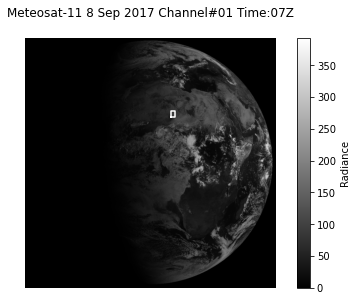

<ipython-input-204-b05d544c6ed9>:168: RuntimeWarning: divide by zero encountered in true_divide
  self.data = R1 / w / np.log( 1.0 + R2/(w**5 * self.data*1e6) )


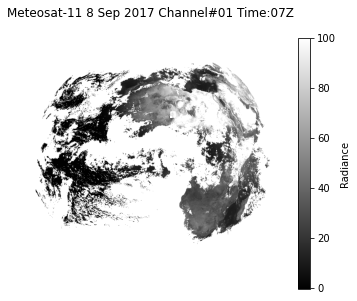

In [209]:
c1 = Image('msg_c01_z{}.img'.format(hour_str))  # Load plain image and display with box
c1.disp(box=box)

c1t = Image('msg_c01_z{}.img'.format(hour_str)) # Load image, cloud clear then display
c1t.clouds(hour)
c1t.disp(box=box)

Crop the box and display in new image:

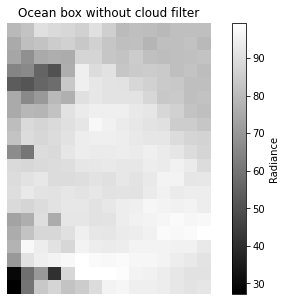

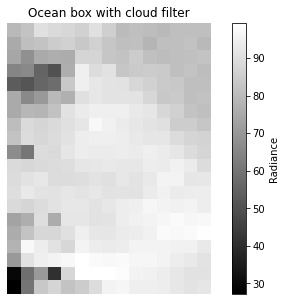

540
635
The centre of the box is located at (lat,lon) (19.89489277936919,10.135939787586844) degrees


In [210]:
c1box = c1.clip(box,title='Ocean box without cloud filter')
c1box.disp()

c1tbox = c1t.clip(box,title='Ocean box with cloud filter')
c1tbox.disp()

# Calc lat lon of box bottom left corner:
print(box['xmin'])
print(box['ymin'])


(lat,lon,zen) = geo.locate(0.5*(xmin+xmax),0.5*(ymin+ymax))
print("The centre of the box is located at (lat,lon) (" + str(lat) +","+ str(lon) + ") degrees")

Show scatter graph for the box area:

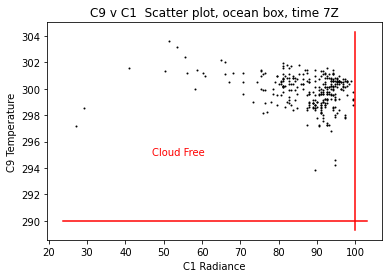

In [211]:
# load in required channel 1&9 images for cloud clearing:
c1 = Image('msg_c01_z{}.img'.format(hour_str))
c9 = Image('msg_c09_z{}.img'.format(hour_str))

# Crop images to box
c1box = c1.clip(box)
c9box = c9.clip(box)

# Convert channel 9 radiance to brightness temperature
c9box.bright(wavelength=10.79)

# convert 2D images to 1D arrays
c1vec = c1box.data.flatten()
c9vec = c9box.data.flatten()

# Set the threshold values AS DISPLAYED ON SCATTER PLOT (for actual cloud clearing, need to change the function)
c9cld = 290   # Brightness temp (K)
c1cld = 100   # Radiance threshold

#(Create scatter plot of all points)
plt.figure(3)
plt.clf()
plt.title('C9 v C1  Scatter plot, ocean box, time ' + str(hour) + 'Z')
plt.xlabel('C1 Radiance')
plt.ylabel('C9 Temperature')
plt.scatter(c1vec,c9vec,s=1,color='black')
#plt.show()

#(Add the threshold values to the scatter plot)
plt.plot(plt.xlim(), [c9cld,c9cld],color='red')
plt.plot([c1cld,c1cld],plt.ylim(),color='red')
plt.text(47,295,'Cloud Free',color='red')
plt.show()

# Calculating radiances:

Calculate average (ch1) radiance in the box:

In [212]:
c1radvec = c1tbox.data.flatten() #Turn the data into 1D
print(len(c1radvec))
# remove the radiance values that have been set to 100 (as this was done by the cloudmask)
c1radvec = c1radvec[c1radvec!=100]
print(len(c1radvec))
R1_ocean = (np.sum(c1radvec))/len(c1radvec)
print('R1 over the ocean is ' + str(R1_ocean) + ' W m^2 sr um.')

300
300
R1 over the ocean is 87.29750123333334 W m^2 sr um.


Now, for all daylight hours: calculate the average channel 1 radiance in the box (make loop doing above few cells actions)

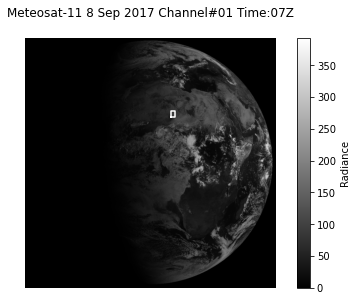

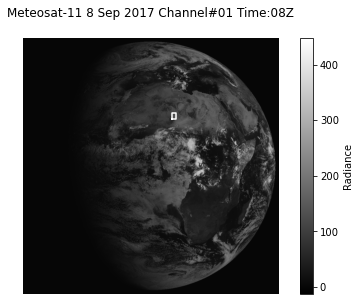

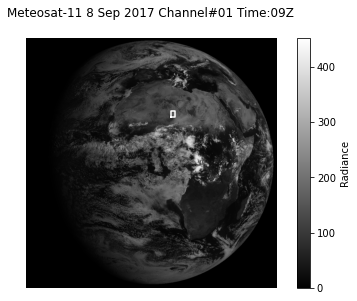

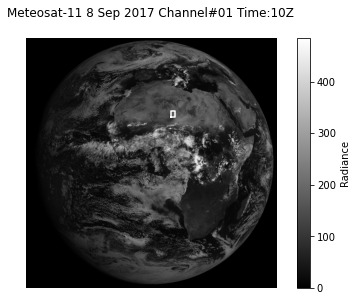

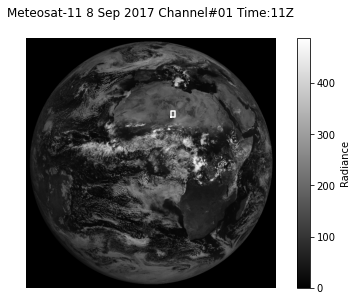

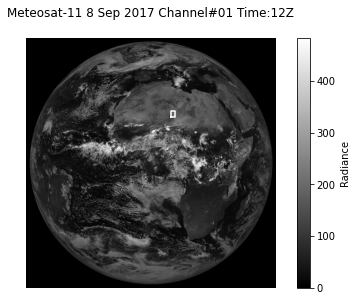

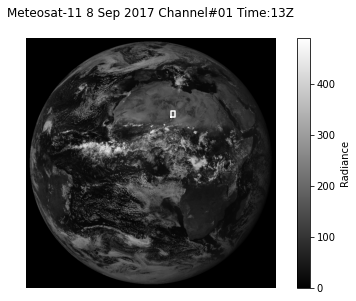

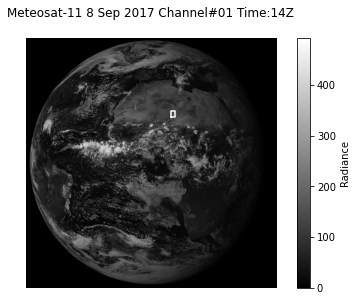

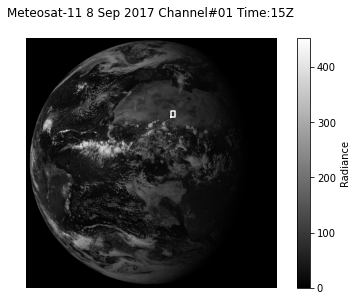

[  0.           0.           0.           0.           0.
   0.          87.29750123 126.64457274 157.34818921 179.02830331
 190.97363506 189.96424413 172.22929692 142.84712819 102.66848614
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]


In [213]:
# Create vector to store radiance values
oceanradiance = np.zeros(24)

# Create vector to store standard error on the mean of the radiance values:
meas_rad_err = np.zeros(24)

# i = hour in Z time, start and end are defined where the boxes are defined

for i in range(start,(end+1)):
    # Load the required image
    if i < 10:
        c1_rad_img = Image('msg_c01_z0' + str(i) +'.img')
    else:
        c1_rad_img = Image('msg_c01_z' + str(i) +'.img')
    
    # Apply the cloud filter:
    #c1_rad_img = c1_rad_img.clouds(i) # COMMENT THIS LINE OUT TO USE *WITHOUT* CLOUD FILTER
    c1_rad_img.disp(box=box)
    
    # Apply the box:
    c1clipped = c1_rad_img.clip(box)
    #c1clipped.disp()
    # Calculate average radiance:
    c1radvec = c1clipped.data.flatten() # Turn the data into 1D
    c1radvec = c1radvec[c1radvec!=100] # Remove cloud data values
    oceanradiance[i-1] = (np.sum(c1radvec))/len(c1radvec) # Calculate average

    # Calculate standard error on the mean for each value:
    delta_square = np.square(c1radvec - oceanradiance[i-1])    # Elementwise subtract mean from individual pixels and square
    sigma = np.sqrt((np.sum(delta_square))/(len(c1radvec)-1))
    meas_rad_err[i-1] = sigma/np.sqrt(len(c1radvec))
    
print(oceanradiance)

Plot the radiance values for across the daytime:

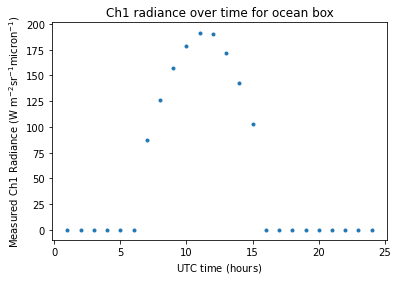

In [214]:
time = np.arange(1,24+1,1)
plt.errorbar(time, oceanradiance, yerr=meas_rad_err, fmt='.')
plt.title("Ch1 radiance over time for ocean box")
plt.xlabel("UTC time ($\mathregular{hours}$)")
plt.ylabel("Measured Ch1 Radiance (W $\mathregular{m^{-2} sr^{-1} micron^{-1}}$)")
plt.show()

Numerical integration of Planck function * channel parameter:

In [215]:
## Original Planck function:

# # Define Planck function:
# def planck(wavelength,T):
#     # Inputs:
#         # wavelength in MICRONS
#         # temperature in K
#     # Output:
#         # Spectral radiance in W m^-2 sr^-1 um^-1
    
#     a = 1.19*(10**8)
#     b = 14309
    
#     return a/((wavelength**5)*(np.exp(b/(wavelength*T))-1))

# Improved Planck function: more accurate constants
def planck2(wavelength,T):
    # Inputs:
        # wavelength in MICRONS
        # temperature in K
    # Output:
        # Spectral radiance in W m^-2 sr^-1 um^-1
    
    a = 1.191030363*(10**8)
    b = 14388.12709
    
    return a/((wavelength**5)*(np.exp(b/(wavelength*T))-1))

print(planck(0.64,5800))
print(planck2(0.64,5800))

23978777.21284879
23482649.855529755


In [216]:
# Import spectral response function data:

df = pd.read_csv("SRF.csv")

lambda1 = df.lambda1.values
res1 = df.res1.values

lambda1 = lambda1[~np.isnan(lambda1)]
res1 = res1[~np.isnan(res1)]


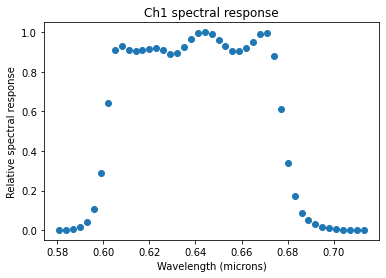

In [217]:
# Plot the (unscaled) spectral response function for channel 1
plt.scatter(lambda1,res1)
plt.title("Ch1 spectral response")
plt.ylabel("Relative spectral response")
plt.xlabel("Wavelength (microns)")
plt.show()

In [218]:
# Numerically integrate: (integrating over the (unscaled) spectral response function)
from scipy import integrate
result = integrate.simps(res1,lambda1)
print(result)

0.07448300000000008


In [219]:
# Scale the spectral response function values such that its integral over the wavelength range is unity
res1 = (1/result)*res1
result = integrate.simps(res1,lambda1)
print(result)

0.9999999999999998


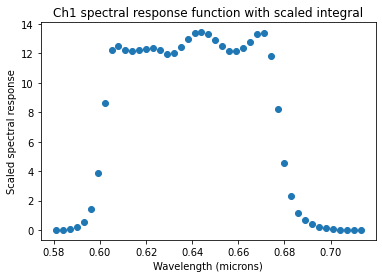

In [220]:
plt.scatter(lambda1,res1)
plt.title("Ch1 spectral response function with scaled integral")
plt.ylabel("Scaled spectral response")
plt.xlabel("Wavelength (microns)")
plt.show()

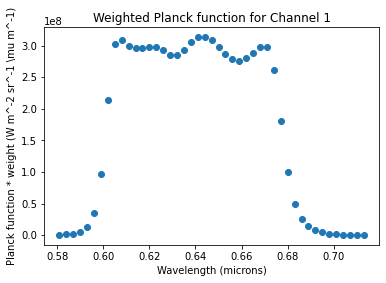

In [221]:
# Create array of the Planck function * SRF:
Plankweighted = np.zeros(len(res1))
for i in range(0,(len(res1))):
    Plankweighted[i] = planck2(lambda1[i],5800)*res1[i]
    
plt.scatter(lambda1,Plankweighted)
plt.title("Weighted Planck function for Channel 1")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Planck function * weight (W m^-2 sr^-1 \mu m^-1)")
plt.show()

In [222]:
# Integrate weighted Planck function over the wavelength range:
integral = integrate.simps(Plankweighted,lambda1)
print(integral)

23450733.489703007


Define scaling factor beta:

In [223]:
beta = ((696*(10**3))/(150*(10**6)))**2

In [224]:
print("The test albedo is approximately " + str(40/(integral*beta)))

The test albedo is approximately 0.07922597619753369


# Function to calculate cos of the solar zenith angle: (WIP)

Calculate declination (function):

In [225]:
# Assume zenith angle ~constant throughout the day:
def dec(d):
    # Input: number of days since the beginning of the year
    # Outputs:
        # Declination angle in degrees
        # Error in declination angle: assumed to be ~ approx the day-to-day variation (as this is a crude approximation)
    # See:
    answer = -23.45*np.cos((360/365)*(d+10)*(np.pi/180))
    error = np.absolute(-23.45*np.cos((360/365)*(d+10)*(np.pi/180))) - (-23.45*np.cos((360/365)*(d+11)*(np.pi/180)))
    return answer, error

#print(dec(251))

Calculate cos(zenith angle) using the above functions:

In [226]:
day = 251 # 8th Sept: 251st day of year in non-leap year, so 250th day with Jan 1st as day 0

def coszen(t,d,lat,lon):
    # Inputs:
        # t: time of day in UTC (Z time)
        # lat: latitude (in degrees) of location
        # day: integer number of days into the year, starting at 1 on the 1st Jan
        # lon: longitude (in degrees) of location
    # Outputs:
        # Cosine of the zenith angle (unitless)
        # Derived error in cos(zenith angle)

    # Convert latitude, longitude to radians:
    lat = lat*(np.pi/180)
    lon = lon*(np.pi/180)
    
    # Determine declination and error:
    declin,declin_err = dec(day)
    # Convert both to radians:
    declin = (np.pi/180)*declin
    declin = 5.51*(np.pi/180)            # If wanting to use databook value
    declin_err = (np.pi/180)*declin_err

    
    # Determine hour angle = lambda_sun - lambda_observer:
    
    # Equation of time
    eot = 2+(22/60)      # See http://www.precisedirections.co.uk/Sundials/4_Year_EoT.html  (need to find a concrete source, or calculate manually)
    eot_err = 20/60      # Approx/error estimate, might need more concrete idea but is ~ day to day variation
    
    # Calculate longitude of subsolar point (in degrees)
    l_s = (-15)*(t-12+(eot/60))      # See https://www.sciencedirect.com/science/article/pii/S0960148121004031?via%3Dihub
    l_s_err = 1             #TO BE CALCULATED
    
    # Convert to radians
    l_s = (np.pi/180)*l_s
    l_s_err = l_s_err*(np.pi/180)
    
    coszenith = np.sin(lat)*np.sin(declin) + np.cos(lat)*np.cos(declin)*np.cos(l_s - lon)
    
    coszen_error = 1
    
    return coszenith,coszen_error


Divide the measured radiance by cos of zenith angle, plot against the integral?

The albedo was calculated as 0.3864587242315926with error 0.0032062512158516827


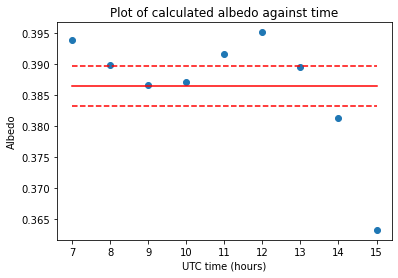

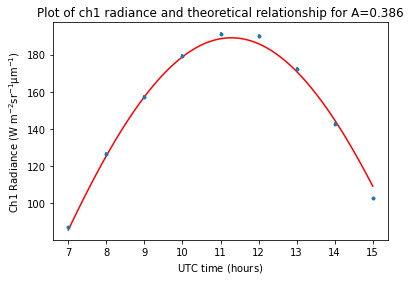

In [227]:
calc_alb = np.zeros(24) # length = 24, entry 0 is time 1Z
time = np.arange(1,24+1,1)

for i in time:
    calc_alb[i-1] = oceanradiance[i-1]/(coszen(i,250,lat,lon)[0]*beta*integral)
    #print(oceanradiance[i-1],coszen(i,250,lat,lon))

# Extract only the values between the start and end times:
columns = np.arange(start-1, end, 1)
#print(columns)
time_plot = time[columns]
calc_alb_plot = calc_alb[columns]
oceanradiance_plot = oceanradiance[columns]
meas_rad_err_plot = meas_rad_err[columns]


alb_mean = np.sum(calc_alb_plot)/len(calc_alb_plot)
alb_delta_square = np.square(calc_alb_plot - alb_mean)    # Elementwise subtract mean from individual pixels and square
alb_sigma = np.sqrt((np.sum(alb_delta_square))/(len(calc_alb_plot)-1))
alb_err = alb_sigma/np.sqrt(len(calc_alb_plot))
print("The albedo was calculated as " + str(alb_mean) + "with error " + str(alb_err))

x = np.linspace(start, end, 100)
albedo_upper = np.zeros(len(x))
albedo_mean = np.zeros(len(x))
albedo_lower = np.zeros(len(x))
for i in range(0,len(albedo_mean)):
    albedo_upper[i] = alb_mean + alb_err
    albedo_mean[i] = alb_mean
    albedo_lower[i] = alb_mean - alb_err

plt.scatter(time_plot,calc_alb_plot)
plt.plot(x,albedo_lower,"--",color="r")
plt.plot(x,albedo_mean,"-",color="r")
plt.plot(x,albedo_upper,"--",color="r")
plt.xlabel("UTC time (hours)")
plt.ylabel("Albedo")
plt.title("Plot of calculated albedo against time")
plt.show()


coszenith = np.zeros(len(x))

for i in range(0,len(coszenith)):
    coszenith[i] = coszen(x[i],250,lat,lon)[0]

plt.errorbar(time_plot, oceanradiance_plot, yerr=meas_rad_err_plot, fmt='.')
plt.plot(x,alb_mean*beta*integral*coszenith,color="r")
plt.xlabel("UTC time ($\mathregular{hours}$)")
plt.ylabel("Ch1 Radiance (W $\mathregular{m^{-2} sr^{-1} \mu m^{-1}}$)")
plt.title(f"Plot of ch1 radiance and theoretical relationship for A={alb_mean:.3f}")

plt.show()

### Ch1:
For desert: we get almost perfect cos curve (without using cloud filter)
For land and ocean: seems to be a flatter ~linear section approximately mid morning: this could (possibly?) be the result of clouds casting shadows on the surface, hence a lower radiance is measured?

Yet to try other SEVIRI channels, but that is the next step
Intend to compute A for at least 2 different locations using an average of measurements from multiple SEVIRI channels for each
Albedo determined by fitting a cos graph to the obtained data, with a corresponding fit error (excluding the night-time points!)


In [228]:
# Checking definition of cos of zenith angle and related parameters:
#t=11+(18/60)
t=15
d=251

print(dec(d))
print((180/np.pi)*np.arccos(coszen(t,d,lat,lon)[0]))

(5.105609752798681, 0.39472623498528314)
55.961630760860714


Deprecated angles that were going to be used, I prefer to estimate my own ones, although we do get an underestimate of up to 0.58 degrees
(Approximation is less accurate near the equinoxes (where it is least accurate) and unfortunately we are in December.


## Might be better to talk about using such an approximation to the declination angle (with the intent of building a function that would work for a general day), however due to the proximity of the dates of the images to an equinox, the accuracy was significantly degraded. As a result, use a value from a data book for the declination on this specific day.

In [229]:
# Define solar declination angles (from NOAA data):
declination_angles = [5.68275,5.667091,5.651428,5.635764,5.620096,5.604425,5.588752,5.573076,5.557398,5.541717,5.526033,5.510346,5.494657,5.478965,5.46327,5.447573,5.431873,5.416171,5.400466,5.384750,5.369047,5.353334,5.337619,5.3219]

print(declination_angles[1])
# See: https://gml.noaa.gov/grad/solcalc/calcdetails.html for details on calculation
# These were applicable for desert box 2, need a way of calculating for ALL locations more accurately

5.667091
